## Data processing and plotting for figure04

This notebook shows how we obtained the data for figure04 of the paper titled:

$\textit{A facility for cryogenic ion irradiation and in operando characterization of Rare-Earth Barium Copper Oxide superconducting tapes}$ by A.R Devitre, D.X. Fischer, K.B. Woller, B.C. Clark, M.P. Short, D.G. Whyte, and Z.S. Hartwig, published by the Review of Scientific Instruments. 

In particular, the notebook follows the treatment of our data treatment from raw data files (provided in ~/data/figure04/) to the production figure. This figure can be regenerated, modified, exported and used according to the license of the repository.

In [1]:
%matplotlib notebook
import sys
from scipy.optimize import curve_fit
import matplotlib, matplotlib.pyplot as plt
import os, numpy as np, pandas as pd
import hts_fitting as hts

def polynomial(x, a, b, c, d):
    return a*x**3+b*x**2+c*x**1+d

# Change this to match the destination folder with data for figure04
parentDirectory = '../data/figure04/'
outputDirectory = '../figures/raw/'

# Change this if you want labels on the figure axes
forPaper = False

# set a custom font
from matplotlib import font_manager
fontname = 'Century Gothic' 
fontfile = [f for f in font_manager.findSystemFonts(fontpaths='/Users/alexisdevitre/Library/Fonts') if fontname in f][0]
font_manager.fontManager.addfont(fontfile)
plt.rcParams['font.family'] = fontname

/Users/alexisdevitre/Documents/GitHub/2024-CryoHTS-Facility/code/hts_fitting.py:58: RuntimeWarning: invalid value encountered in log
  current, voltage = np.log(current), np.log(voltage)


<IPython.core.display.Javascript object>


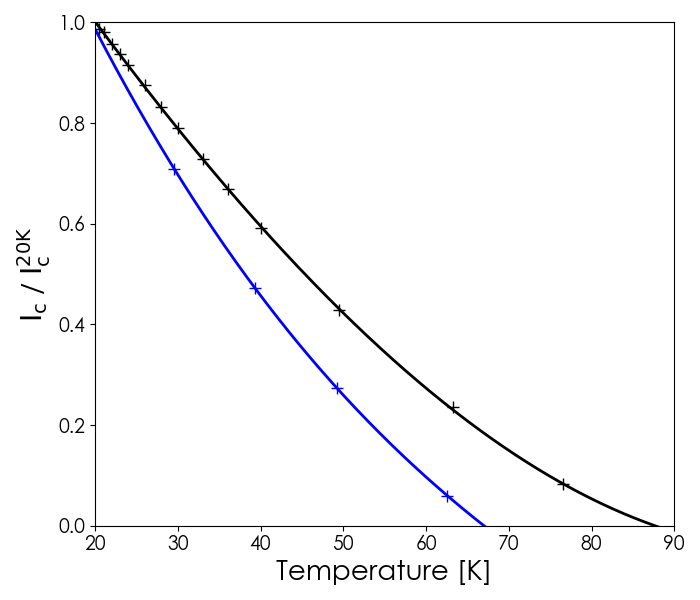

In [2]:
# fetch files for "non-irradiated" curve
fpaths_unirradiated = [parentDirectory+'unirradiated/'+f for f in np.sort(os.listdir(parentDirectory+'unirradiated/')) if f[-4:] == '.txt']
# fetch files for "irradiated" curve
fpaths_irradiated = [parentDirectory+'irradiated/'+f for f in np.sort(os.listdir(parentDirectory+'irradiated/')) if f[-4:] == '.txt']

data_dict = []
for fpaths in [fpaths_unirradiated, fpaths_irradiated]:
    ics, temperatures, setTs = [], [], []
    for fpath in fpaths:
        ic, n, current, voltage, chisq, pcov = hts.fitIcMeasurement(fpath, fformat='mit', function='powerLaw', vMax=20e-6, vb=False)
        _, _, temperature = hts.readIV(fpath)
        setTs.append(fpath.split('.txt')[0].split('_')[-1].split('-')[-1])
        ics.append(float(ic))
        temperatures.append(float(np.nanmean(temperature[1][-10:])))

    data_dict.append({'ic': ics, 'temperature': temperatures, 'setT': setTs})
    
unirradiated = pd.DataFrame(data_dict[0]).dropna().sort_values(by='temperature')
irradiated = pd.DataFrame(data_dict[1]).dropna().sort_values(by='temperature')


fig, ax = plt.subplots(figsize=(7, 6))
ax.set_xlim(20, 90)
ax.set_xticks([20, 30, 40, 50, 60, 70, 80, 90])
ax.set_ylim(0, 1)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('$\mathrm{I_c}$ / $\mathrm{I_c^{20K}}$')

popts = []
for data, c in zip([unirradiated, irradiated], ['k', 'b']):
    means, stds = data.groupby('setT').mean(), data.groupby('setT').std()
    x, y, dy = means.temperature, means.ic/means.ic[0], stds.ic/means.ic
    popt, pcov = curve_fit(polynomial, x, means.ic)
    popts.append(popt)
    xsmooth = np.arange(20, 90, 0.1)
    ysmooth = polynomial(xsmooth, *popt)/means.ic[0]
    ax.plot(xsmooth, ysmooth, color=c, alpha=1, linewidth=2)
    ax.plot(x, y, color=c, marker='+', linestyle='None')

'''
rows, columns = ('Unirradiated', 'Irradiated'), ['Fluence', '$\mathrm{x^3}$', '$\mathrm{x^2}$', '$\mathrm{x}$', '1'] 
index = np.arange(len(columns)) + 0.3
bar_width = 0.4
y_offset = np.zeros(len(columns))
cell_text = [
    ['0e20 $\mathrm{m^{-2}}$', '{:4.2e}'.format((1/34)*popts[0][0]), '{:4.2e}'.format((1/34)*popts[0][1]), '{:4.4f}'.format((1/34)*popts[0][2]), '{:4.2f}'.format((1/34)*popts[0][3])],
    ['6e20 $\mathrm{m^{-2}}$', '{:4.2e}'.format((1/5.54)*popts[1][0]), '{:4.2e}'.format((1/5.54)*popts[1][1]), '{:4.4f}'.format((1/5.54)*popts[1][2]), '{:4.2f}'.format((1/5.54)*popts[1][3])]
]
table = plt.table(cellText=cell_text, cellLoc='center', colLabels=columns, colWidths=[.2,.2,.2,.2, .2], loc='top', fontsize=6)
table.auto_set_font_size(False)
#table.set_fontsize(6)

for i, c in zip([1, 2], ['b', 'r']):
    for j in [1, 2, 3, 4]:
        table[(i, j)].get_text().set_color(c)
        
for k, cell in table._cells.items():
    cell.set_edgecolor('k')
    cell.set_linewidth(0.5)
    cell.set_text_props(fontsize=12, weight='normal', color='black')

table.scale(1,2)
'''

fig.tight_layout()

ax.set_rasterized(True)
plt.savefig(outputDirectory+'figure04.svg')

In [15]:
x1, x2 = 20, 20.31

y1 = polynomial(x1, *popts[1])
y2 = polynomial(x2, *popts[1])
100*(1-y2/y1)

0.9908732084455307